# 주택 가격 예측
- 데이터: 주택별 건축 연도, 설비, 넓이 등 설명 변수 79개와 목적변수인 주택 가격
- 예측 정확도 평가: 평균 제곱 오차(RMSE)
- 연속적인 값을 예측하는 회귀 분석 사용

분류: 클래스 두 개 혹은 여러개로 분류<br>
회귀: 연속된 값을 예측

값에 로그를 취해서 차이를 작게 만들어 특정 데이터가 평가에 영향을 미치는 정도를 줄인다. 

## 1. 데이터 분석 준비
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

#### 디렉터리 구성
C:\kaggle\house-prices\data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

plt.style.use('ggplot')

In [2]:
import random
np.random.seed(1234)
random.seed(1234)

In [3]:
train_df=pd.read_csv('C:/kaggle/house-prices/data/train.csv')
test_df=pd.read_csv('C:/kaggle/house-prices/data/test.csv')
submission=pd.read_csv('C:/kaggle/house-prices/data/sample_submission.csv')

In [4]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. 벤치마크용 베이스라인 작성
#### 학습 데이터의 변수 유형 확인하기
lightgbm에서 읽을 수 있는 것은 int, float, bool뿐이다 

In [5]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [6]:
train_df['MSZoning'].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### 학습 데이터와 테스트 데이터를 합해서 전처리하기
예측을 실행할 때는 SalePrice 값 유무를 사용해서 학습 데이터와 테스트 데이터로 분할한다.

In [7]:
#합칠때 인덱스 새로 매기기
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)
all_df


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [8]:
all_df['SalePrice']

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914         NaN
2915         NaN
2916         NaN
2917         NaN
2918         NaN
Name: SalePrice, Length: 2919, dtype: float64

#### 카테고리 변수를 수치로 변환하기

In [9]:
from sklearn.preprocessing import LabelEncoder
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [10]:
all_df['Alley'].value_counts()

Grvl    120
Pave     78
Name: Alley, dtype: int64

#### 결측치를 수치로 변환하기

In [11]:
for cat in categories:
    #수치로 변환
    le=LabelEncoder()
    print(cat)
    
    all_df[cat].fillna('missing',inplace=True)
    le=le.fit(all_df[cat])
    all_df[cat]=le.transform(all_df[cat])
    #카테고리 변수임을 명시
    all_df[cat]=all_df[cat].astype('category')

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [12]:
all_df

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.0,8450,1,2,3,3,0,...,0,3,4,4,0,2,2008,8,4,208500.0
1,2,20,3,80.0,9600,1,2,3,3,0,...,0,3,4,4,0,5,2007,8,4,181500.0
2,3,60,3,68.0,11250,1,2,0,3,0,...,0,3,4,4,0,9,2008,8,4,223500.0
3,4,70,3,60.0,9550,1,2,0,3,0,...,0,3,4,4,0,2,2006,8,0,140000.0
4,5,60,3,84.0,14260,1,2,0,3,0,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,4,21.0,1936,1,2,3,3,0,...,0,3,4,4,0,6,2006,8,4,NaN
2915,2916,160,4,21.0,1894,1,2,3,3,0,...,0,3,4,4,0,4,2006,8,0,NaN
2916,2917,20,3,160.0,20000,1,2,3,3,0,...,0,3,4,4,0,9,2006,8,0,NaN
2917,2918,85,3,62.0,10441,1,2,3,3,0,...,0,3,2,2,700,7,2006,8,4,NaN


#### train_df와 test_df로 되돌리기

In [13]:
train_df_le=all_df[~all_df['SalePrice'].isnull()]
test_df_le=all_df[all_df['SalePrice'].isnull()]

#### LightGBM으로 데이터 읽기

In [14]:
import lightgbm as lgb

In [15]:
#교차검증
from sklearn.model_selection import KFold
folds=3
kf=KFold(n_splits=folds)

In [16]:
#하이퍼파라미터 설정
lgbm_params={
    'objective':'regression',
    'random_seed':1234
}

In [17]:
train_X=train_df_le.drop(['SalePrice','Id'],axis=1)
train_Y=train_df_le['SalePrice']

In [18]:
from sklearn.metrics import mean_squared_error

In [19]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    print(X_train)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

      MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
487           20        3         70.0    12243      1     2        0   
488          190        3         60.0    10800      1     2        3   
489          180        4         21.0     1526      1     2        3   
490          160        4          NaN     2665      1     2        3   
491           50        3         79.0     9490      1     2        3   
...          ...      ...          ...      ...    ...   ...      ...   
1455          60        3         62.0     7917      1     2        3   
1456          20        3         85.0    13175      1     2        3   
1457          70        3         66.0     9042      1     2        3   
1458          20        3         68.0     9717      1     2        3   
1459          20        3         75.0     9937      1     2        3   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC Fence  \
487            3         0         4  ...   

In [20]:
sum(rmses)/len(rmses)

0.13697846250952908

In [21]:
actual_pred_df=pd.DataFrame({
    'actual':train_Y,
    'pred':oof
})

<AxesSubplot:>

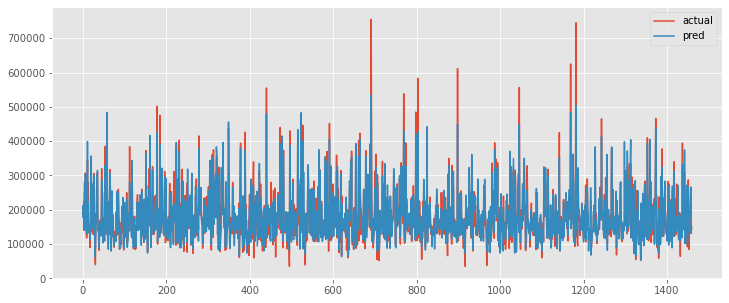

In [22]:
actual_pred_df.plot(figsize=(12,5))

#### 각 변수의 중요도 확인

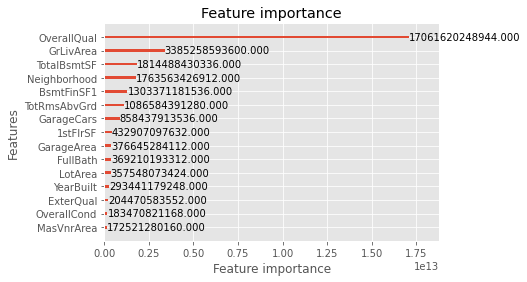

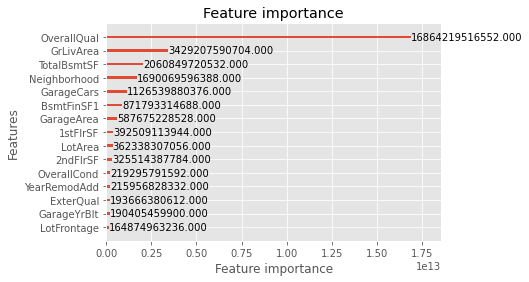

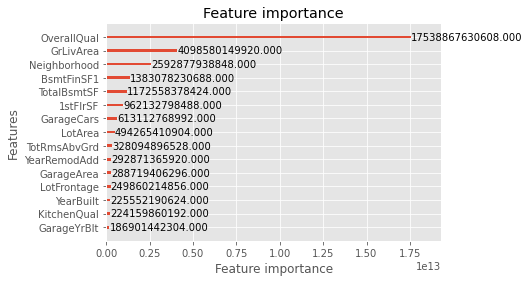

In [23]:
#표시될 변수의 수 제한
for model in models:
    lgb.plot_importance(model,importance_type='gain',max_num_features=15)

## 3. 목적 변수의 전처리:목적 변수의 분포 확인
#### SalePrice 데이터의 분포 확인

In [24]:
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:ylabel='Frequency'>

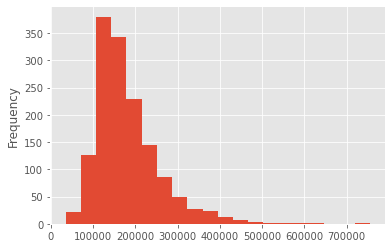

In [25]:
train_df['SalePrice'].plot.hist(bins=20)

푸아송 분포
- 잘 일어나지 않는 사건이 실제로 일어날 확률의 분포를 나타날때 이용
- 왼쪽으로 치우친다

In [26]:
#로그화
np.log(train_df['SalePrice'])

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

<AxesSubplot:ylabel='Frequency'>

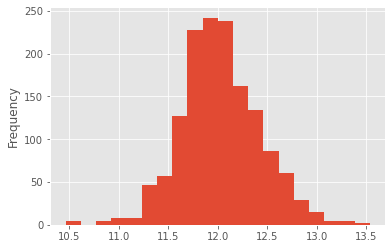

In [27]:
np.log(train_df['SalePrice']).plot.hist(bins=20)

In [28]:
pd.options.mode.chained_assignment=None
train_df_le['SalePrice_log']=np.log(train_df_le['SalePrice'])

In [29]:
train_X=train_df_le.drop(['SalePrice','SalePrice_log','Id'],axis=1)
train_Y=train_df_le['SalePrice_log']

In [30]:
import warnings
warnings.filterwarnings("ignore")

models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0435757
[20]	valid_0's l2: 0.0223987
[30]	valid_0's l2: 0.0176962
[40]	valid_0's l2: 0.0164304
[50]	valid_0's l2: 0.0161943
[60]	valid_0's l2: 0.0161858
[70]	valid_0's l2: 0.0161666
[80]	valid_0's l2: 0.0161769
[90]	valid_0's l2: 0.0162121
Early stopping, best iteration is:
[73]	valid_0's l2: 0.0161129
0.12693572281592597
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0480056
[20]	valid_0's l2: 0.0274907
[30]	valid_0's l2: 0.022779
[40]	valid_0's l2: 0.0214744
[50]	valid_0's l2: 0.0209095
[60]	valid_0's l2: 0.0205922
[70]	valid_0's l2: 0.0204381
[80]	valid_0's l2: 0.0203135
[90]	valid_0's l2: 0.020318
[100]	valid_0's l2: 0.0202246
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.0202246
0.1422133338842566
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0388654
[20]	valid_0's l2: 0.0209198
[30]	valid_0's l2: 0.0176337

In [31]:
sum(rmses)/len(rmses)

0.13284034805621694

정확도가 높아졌다.

## 4. 설명 변수의 전처리: 결측치 확인

In [32]:
all_df=pd.concat([train_df,test_df],sort=False).reset_index(drop=True)

In [33]:
categories=all_df.columns[all_df.dtypes=='object']
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [34]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageFinish      159
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageType        157
BsmtExposure       82
BsmtCond           82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MasVnrArea         23
MSZoning            4
Functional          2
BsmtHalfBath        2
BsmtFullBath        2
Utilities           2
BsmtFinSF1          1
BsmtFinSF2          1
SaleType            1
Electrical          1
GarageCars          1
TotalBsmtSF         1
GarageArea          1
Exterior2nd         1
Exterior1st         1
KitchenQual         1
BsmtUnfSF           1
Fireplaces          0
TotRmsAbvGrd        0
SaleCondition       0
OpenPorchSF         0
YrSold              0
dtype: int64

In [35]:
all_df.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [36]:
#결과값 있으면 1 없으면 0
all_df.loc[~all_df['PoolQC'].isnull(),'PoolQC']=1
all_df.loc[all_df['PoolQC'].isnull(),'PoolQC']=0

In [37]:
all_df.PoolQC.value_counts()

0    2909
1      10
Name: PoolQC, dtype: int64

In [38]:
#MiscFeature, Alley도 똑같이 처리
all_df.loc[~all_df['MiscFeature'].isnull(),'MiscFeature']=1
all_df.loc[all_df['MiscFeature'].isnull(),'MiscFeature']=0

all_df.loc[~all_df['Alley'].isnull(),'Alley']=1
all_df.loc[all_df['Alley'].isnull(),'Alley']=0

In [39]:
#for문으로 편하게 작업
HighFacility_col=['PoolQC','MiscFeature','Alley']
for col in HighFacility_col:
    if all_df[col].dtype=='object':
        if len(all_df[all_df[col].isnull()])>0:
            all_df.loc[~all_df[col].isnull(),col]=1
            all_df.loc[all_df[col].isnull(),col]=0

In [40]:
#새로운 고급 설비 변수 생성
all_df['hasHighFacility']=all_df['PoolQC']+all_df['MiscFeature']+all_df['Alley']

In [41]:
all_df['hasHighFacility']=all_df['hasHighFacility'].astype(int)

In [42]:
all_df['hasHighFacility'].value_counts()

0    2615
1     295
2       9
Name: hasHighFacility, dtype: int64

In [43]:
all_df=all_df.drop(['PoolQC','MiscFeature','Alley'],axis=1)

## 5.이상치 제외
크기가 너무 넓거나 방 개수가 너무 많은 주택 등 일반적인 경향과 다른 데이터가 있는지 확인한다.
#### 이상치란
- 통상적인 경향과 다른 값
- 이상치가 존재하면 예측 정확도가 떨어진다

#### 변수의 통계량 확인하기

In [44]:
all_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Id,2919.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
MSSubClass,2919.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
LotFrontage,2433.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
LotArea,2919.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
OverallQual,2919.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
OverallCond,2919.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
YearBuilt,2919.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
YearRemodAdd,2919.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
MasVnrArea,2896.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
BsmtFinSF1,2918.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


#### 수치 데이터만 추출하기
수치 데이터 여부 np.number로 파악

In [45]:
train_df_num=train_df.select_dtypes(include=[np.number])

In [46]:
#비례척도가 아닌 것
nonratio_features=['Id','MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','MoSold','YrSold']

In [47]:
# 비례척도인 수치 데이터
num_features=sorted(list(set(train_df_num)-set(nonratio_features)))

In [48]:
num_features

['1stFlrSF',
 '2ndFlrSF',
 '3SsnPorch',
 'BedroomAbvGr',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtFullBath',
 'BsmtHalfBath',
 'BsmtUnfSF',
 'EnclosedPorch',
 'Fireplaces',
 'FullBath',
 'GarageArea',
 'GarageCars',
 'GarageYrBlt',
 'GrLivArea',
 'HalfBath',
 'KitchenAbvGr',
 'LotArea',
 'LotFrontage',
 'LowQualFinSF',
 'MasVnrArea',
 'MiscVal',
 'OpenPorchSF',
 'PoolArea',
 'SalePrice',
 'ScreenPorch',
 'TotRmsAbvGrd',
 'TotalBsmtSF',
 'WoodDeckSF']

In [49]:
train_df_num_rs=train_df_num[num_features]

#### 다수의 데이터가 0인 변수 확인하기

In [50]:
for col in num_features:
    if train_df_num_rs.describe()[col]['75%']==0:
        print(col,len(train_df_num_rs[train_df_num_rs[col]==0]))

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


#### 특정 값만 가지는 변수 확인하기

In [51]:
for col in num_features:
    if train_df_num_rs[col].nunique()<15:
        print(col,train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
PoolArea 8
TotRmsAbvGrd 12


#### 이상치가 있는지 확인하기
평균에서 표준 편차 +-3배 범위에 들어 있지 않은 것

In [52]:
for col in num_features:
    tmp_df=train_df_num_rs[(train_df_num_rs[col]>train_df_num_rs[col].mean()+
            train_df_num_rs[col].std()*3)| \
            (train_df_num_rs[col]<train_df_num_rs[col].mean()-
            train_df_num_rs[col].std()*3)]
    print(col,len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22


<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

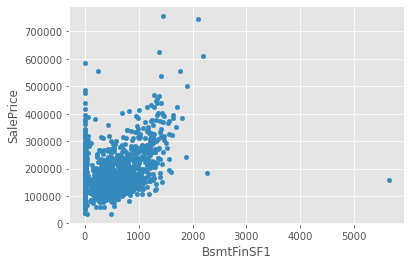

In [53]:
all_df.plot.scatter(x='BsmtFinSF1',y='SalePrice')

BsmtFinSF1 0인것도 있고 오른쪽으로 이동할수록 SalePrice 높아지는 경향

In [54]:
all_df[all_df['BsmtFinSF1']>5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

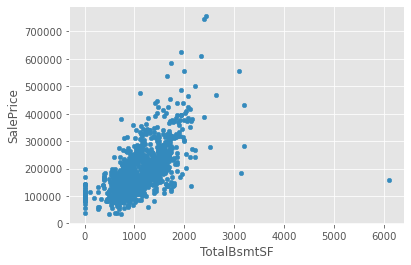

In [55]:
all_df.plot.scatter(x='TotalBsmtSF',y='SalePrice')

In [56]:
all_df[all_df['TotalBsmtSF']>6000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1


<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

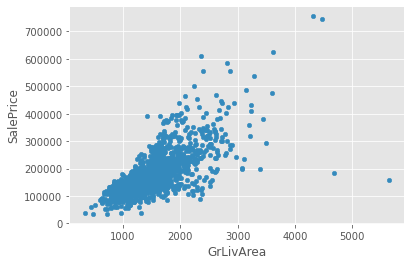

In [57]:
all_df.plot.scatter(x='GrLivArea',y='SalePrice')

In [58]:
all_df[all_df['GrLivArea']>5000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

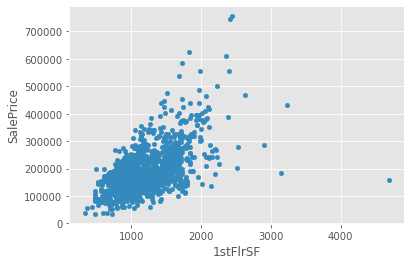

In [59]:
all_df.plot.scatter(x='1stFlrSF',y='SalePrice')

In [60]:
all_df[all_df['1stFlrSF']>4000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,Corner,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,Inside,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [61]:
all_df=all_df[(all_df['BsmtFinSF1']<2000)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['TotalBsmtSF']<3000)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['GrLivArea']<4500)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['1stFlrSF']<2500)|(all_df['SalePrice'].isnull())]
all_df=all_df[(all_df['LotArea']<100000)|(all_df['SalePrice'].isnull())]

In [62]:
categories=categories.drop(['PoolQC','MiscFeature','Alley'])

In [63]:
for cat in categories:
    le=LabelEncoder()
    print(cat)
    
    all_df[cat].fillna('missing',inplace=True)
    le=le.fit(all_df[cat])
    all_df[cat]=le.transform(all_df[cat])
    all_df[cat]=all_df[cat].astype('category')
    

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [64]:
#분할하기
train_df_le=all_df[~all_df['SalePrice'].isnull()]
test_df_le=all_df[all_df['SalePrice'].isnull()]

train_df_le['SalePrice_log']=np.log(train_df_le['SalePrice'])
train_X=train_df_le.drop(['SalePrice','SalePrice_log','Id'],axis=1)
train_Y=train_df_le['SalePrice_log']

In [65]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0424478
[20]	valid_0's l2: 0.0222118
[30]	valid_0's l2: 0.0175757
[40]	valid_0's l2: 0.0165142
[50]	valid_0's l2: 0.0164264
[60]	valid_0's l2: 0.016285
[70]	valid_0's l2: 0.0163922
[80]	valid_0's l2: 0.0163238
Early stopping, best iteration is:
[62]	valid_0's l2: 0.0162509
0.12745948164738202
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.047333
[20]	valid_0's l2: 0.0272932
[30]	valid_0's l2: 0.0223134
[40]	valid_0's l2: 0.0209381
[50]	valid_0's l2: 0.0203039
[60]	valid_0's l2: 0.0200215
[70]	valid_0's l2: 0.0197188
[80]	valid_0's l2: 0.0196559
[90]	valid_0's l2: 0.0195579
[100]	valid_0's l2: 0.0195231
Did not meet early stopping. Best iteration is:
[99]	valid_0's l2: 0.0195208
0.13971669031954484
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0368757
[20]	valid_0's l2: 0.0197062
[30]	valid_0's l2: 0.0167971
[40]	valid_0's l2: 0.0158749

In [66]:
sum(rmses)/len(rmses)

0.13039701843269016

## 6. 설명 변수 확인: 특징 값 생성

#### 시간 관련된 변수의 통계량 확인하기

In [67]:
all_df[['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']].describe()

,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
count,2904.000000,2904.000000,2745.000000,2904.000000
mean,1971.234504,1984.217975,1978.061202,2007.792011
std,30.319059,20.907346,25.600996,1.316366
min,1872.000000,1950.000000,1895.000000,2006.000000
25%,1953.000000,1965.000000,1960.000000,2007.000000
50%,1973.000000,1993.000000,1979.000000,2008.000000
75%,2001.000000,2004.000000,2002.000000,2009.000000
max,2010.000000,2010.000000,2207.000000,2010.000000


In [68]:
all_df['Age']=all_df['YrSold']-all_df['YearBuilt']

In [69]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [70]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0427712
[20]	valid_0's l2: 0.0222468
[30]	valid_0's l2: 0.0177147
[40]	valid_0's l2: 0.016571
[50]	valid_0's l2: 0.0161945
[60]	valid_0's l2: 0.0161879
[70]	valid_0's l2: 0.0161968
Early stopping, best iteration is:
[58]	valid_0's l2: 0.0161388
0.12704034420133195
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0474374
[20]	valid_0's l2: 0.027474
[30]	valid_0's l2: 0.0225527
[40]	valid_0's l2: 0.0207551
[50]	valid_0's l2: 0.0202749
[60]	valid_0's l2: 0.0200399
[70]	valid_0's l2: 0.0198921
[80]	valid_0's l2: 0.0198431
[90]	valid_0's l2: 0.0197761
[100]	valid_0's l2: 0.019663
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.019663
0.14022471834012856
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0369248
[20]	valid_0's l2: 0.0195778
[30]	valid_0's l2: 0.016538
[40]	valid_0's l2: 0.0153916
[50]	valid_0's l2: 0.0149941
[

In [71]:
sum(rmses)/len(rmses)

0.12968959614926723

정확도가 좋아졌다.

In [72]:
all_df[["LotArea","MasVnrArea","BsmtUnfSF","TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea", "GarageArea","WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch","ScreenPorch","PoolArea","LotFrontage"]].describe()

,LotArea,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,LotFrontage
count,2904.000000,2882.000000,2903.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2903.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2904.000000,2425.000000
mean,9912.604683,101.191187,559.850499,1043.794006,1152.707300,336.355372,4.718664,1493.781336,471.632794,93.265840,47.226584,22.988636,2.615702,16.086777,1.907025,69.071340
std,5178.128224,177.804595,438.438879,420.008348,377.291394,427.355787,46.515308,491.149725,214.551791,125.855568,67.195477,64.055325,25.252464,56.245764,33.082892,22.662001
min,1300.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,21.000000
25%,7448.250000,0.000000,220.000000,791.500000,875.750000,0.000000,0.000000,1124.000000,319.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59.000000
50%,9422.000000,0.000000,467.000000,988.000000,1080.000000,0.000000,0.000000,1441.000000,478.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,68.000000
75%,11503.000000,164.000000,802.500000,1296.000000,1381.250000,704.000000,0.000000,1739.250000,576.000000,168.000000,69.250000,0.000000,0.000000,0.000000,0.000000,80.000000
max,70761.000000,1600.000000,2336.000000,5095.000000,5095.000000,1872.000000,1064.000000,5095.000000,1488.000000,1424.000000,742.000000,1012.000000,508.000000,576.000000,800.000000,313.000000


LotArea에 매우 넓은 주택 있고, Porch가 없는 주택이 많다

In [73]:
#각 층의 전체 넓이, 욕실 수의 합계 추가
all_df['TotalSF']=all_df['TotalBsmtSF']+all_df['1stFlrSF']+all_df['2ndFlrSF']
all_df["Total_Bathrooms"] = all_df["FullBath"] + all_df["HalfBath"] + all_df["BsmtFullBath"] + all_df["BsmtHalfBath"]

In [74]:
#Porch 넓이의 합계
all_df["Total_PorchSF"] = all_df["WoodDeckSF"] + all_df["OpenPorchSF"] + all_df["EnclosedPorch"] + all_df["3SsnPorch"] + all_df["ScreenPorch"]

In [75]:
all_df['hasPorch']=all_df['Total_PorchSF'].apply(lambda x: 1 if x > 0 else 0)
all_df=all_df.drop('Total_PorchSF',axis=1)

In [76]:
train_df_le = all_df[~all_df["SalePrice"].isnull()] 
test_df_le = all_df[all_df["SalePrice"].isnull()] 

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [77]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0388049
[20]	valid_0's l2: 0.0199263
[30]	valid_0's l2: 0.0165969
[40]	valid_0's l2: 0.0158728
[50]	valid_0's l2: 0.0157388
[60]	valid_0's l2: 0.015844
Early stopping, best iteration is:
[49]	valid_0's l2: 0.0157164
0.12536497336459065
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0459281
[20]	valid_0's l2: 0.0262784
[30]	valid_0's l2: 0.0217831
[40]	valid_0's l2: 0.0205294
[50]	valid_0's l2: 0.0201039
[60]	valid_0's l2: 0.0198874
[70]	valid_0's l2: 0.019815
[80]	valid_0's l2: 0.0198968
Early stopping, best iteration is:
[65]	valid_0's l2: 0.0197659
0.14059120440349726
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0354828
[20]	valid_0's l2: 0.0183241
[30]	valid_0's l2: 0.0154847
[40]	valid_0's l2: 0.0145868
[50]	valid_0's l2: 0.0143982
[60]	valid_0's l2: 0.0142851
[70]	valid_0's l2: 0.0144113
Early stopping, best iteration is:
[56]	va

In [78]:
sum(rmses)/len(rmses)

0.128396868966143

정확도가 더 향상되었다.

## 7. 하이퍼파라미터 최적화
#### optuna를 이용해 하이퍼파라미터 최적화하기
optuna
1. 모델의 학습 흐름과 개선하려는 정확도를 정의
2. 조정하고자 하는 모델의 하이퍼파라미터 및 탐색 범위를 설정
3. 실행 횟수를  정하여 최적화 실행

In [79]:
#pip install optuna=2.0.0
import optuna

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
#데이터 분할
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

In [82]:
# 하이퍼파라미터 최적화
def objective(trial):
    params = {
        "objective":"regression",
        "random_seed":1234,
        "learning_rate":0.05,        
        "n_estimators":1000,        
        
        "num_leaves":trial.suggest_int("num_leaves",4,64),
        "max_bin":trial.suggest_int("max_bin",50,200),        
        "bagging_fraction":trial.suggest_uniform("bagging_fraction",0.4,0.9),
        "bagging_freq":trial.suggest_int("bagging_freq",1,10),
        "feature_fraction":trial.suggest_uniform("feature_fraction",0.4,0.9),
        "min_data_in_leaf":trial.suggest_int("min_data_in_leaf",2,16),                
        "min_sum_hessian_in_leaf":trial.suggest_int("min_sum_hessian_in_leaf",1,10),
    }
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(params, lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,)    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    score =  np.sqrt(mean_squared_error(y_valid, y_pred))
    
    return score

In [83]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=50)
study.best_params

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0650613
[20]	valid_0's l2: 0.0350252
[30]	valid_0's l2: 0.0243811
[40]	valid_0's l2: 0.0200293
[50]	valid_0's l2: 0.0178734
[60]	valid_0's l2: 0.0172096
[70]	valid_0's l2: 0.0166336
[80]	valid_0's l2: 0.0162864
[90]	valid_0's l2: 0.0160433
[100]	valid_0's l2: 0.0159939
[110]	valid_0's l2: 0.0159343
[120]	valid_0's l2: 0.0157958
[130]	valid_0's l2: 0.0157909


[I 2022-08-22 15:29:12,274] Trial 0 finished with value: 0.1256058007495133 and parameters: {'num_leaves': 48, 'max_bin': 97, 'bagging_fraction': 0.7575946831862097, 'bagging_freq': 4, 'feature_fraction': 0.8289728088113784, 'min_data_in_leaf': 9, 'min_sum_hessian_in_leaf': 10}. Best is trial 0 with value: 0.1256058007495133.
[I 2022-08-22 15:29:12,430] Trial 1 finished with value: 0.1173611265999331 and parameters: {'num_leaves': 23, 'max_bin': 71, 'bagging_fraction': 0.5921908536463499, 'bagging_freq': 8, 'feature_fraction': 0.8458865003910399, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 1 with value: 0.1173611265999331.


[140]	valid_0's l2: 0.0158547
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0157768
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659071
[20]	valid_0's l2: 0.0369222
[30]	valid_0's l2: 0.0249191
[40]	valid_0's l2: 0.0194241
[50]	valid_0's l2: 0.0165927
[60]	valid_0's l2: 0.015663
[70]	valid_0's l2: 0.0148881
[80]	valid_0's l2: 0.0145594
[90]	valid_0's l2: 0.014272
[100]	valid_0's l2: 0.013874
[110]	valid_0's l2: 0.0138832
[120]	valid_0's l2: 0.0137736
[130]	valid_0's l2: 0.013946
[140]	valid_0's l2: 0.0139194
Early stopping, best iteration is:
[120]	valid_0's l2: 0.0137736
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0666901
[20]	valid_0's l2: 0.0370973
[30]	valid_0's l2: 0.0242128
[40]	valid_0's l2: 0.0190476
[50]	valid_0's l2: 0.0166076
[60]	valid_0's l2: 0.0155055
[70]	valid_0's l2: 0.0147474
[80]	valid_0's l2: 0.0145156
[90]	valid_0's l2: 0.0144669
[100]	valid_0's l2: 0.0143792
[110]	valid_0's l2: 

[I 2022-08-22 15:29:12,707] Trial 2 finished with value: 0.11846799475422892 and parameters: {'num_leaves': 42, 'max_bin': 89, 'bagging_fraction': 0.6644474598764523, 'bagging_freq': 9, 'feature_fraction': 0.5963923980504149, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 9}. Best is trial 1 with value: 0.1173611265999331.



Early stopping, best iteration is:
[144]	valid_0's l2: 0.0140347
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0711284
[20]	valid_0's l2: 0.0419267
[30]	valid_0's l2: 0.0288194
[40]	valid_0's l2: 0.0231077
[50]	valid_0's l2: 0.0197809
[60]	valid_0's l2: 0.0183233
[70]	valid_0's l2: 0.0169947
[80]	valid_0's l2: 0.0164551
[90]	valid_0's l2: 0.0160353
[100]	valid_0's l2: 0.0160091


[I 2022-08-22 15:29:12,876] Trial 3 finished with value: 0.12627317575481573 and parameters: {'num_leaves': 13, 'max_bin': 198, 'bagging_fraction': 0.4101091987201629, 'bagging_freq': 4, 'feature_fraction': 0.8785775794765232, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 3}. Best is trial 1 with value: 0.1173611265999331.
[I 2022-08-22 15:29:13,061] Trial 4 finished with value: 0.1249904999869771 and parameters: {'num_leaves': 39, 'max_bin': 79, 'bagging_fraction': 0.7902645881432278, 'bagging_freq': 8, 'feature_fraction': 0.7199605106637619, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 1 with value: 0.1173611265999331.


[110]	valid_0's l2: 0.0161034
Early stopping, best iteration is:
[93]	valid_0's l2: 0.0159449
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653132
[20]	valid_0's l2: 0.0362367
[30]	valid_0's l2: 0.0245103
[40]	valid_0's l2: 0.0199817
[50]	valid_0's l2: 0.0178647
[60]	valid_0's l2: 0.0168934
[70]	valid_0's l2: 0.016315
[80]	valid_0's l2: 0.0160084
[90]	valid_0's l2: 0.0158307
[100]	valid_0's l2: 0.0156713
[110]	valid_0's l2: 0.0158518
Early stopping, best iteration is:
[96]	valid_0's l2: 0.0156226
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0675323
[20]	valid_0's l2: 0.0391375
[30]	valid_0's l2: 0.0271245
[40]	valid_0's l2: 0.0212302
[50]	valid_0's l2: 0.0176689
[60]	valid_0's l2: 0.0162966
[70]	valid_0's l2: 0.0155858
[80]	valid_0's l2: 0.0149288
[90]	valid_0's l2: 0.014583
[100]	valid_0's l2: 0.0143602
[110]	valid_0's l2: 0.0142403
[120]	valid_0's l2: 0.0140153
[130]	valid_0's l2: 0.0139654
[140]	valid_0's l2: 

[I 2022-08-22 15:29:13,398] Trial 5 finished with value: 0.11594545261639481 and parameters: {'num_leaves': 36, 'max_bin': 81, 'bagging_fraction': 0.4529538035938961, 'bagging_freq': 8, 'feature_fraction': 0.5322778060523135, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.11594545261639481.


[190]	valid_0's l2: 0.0135983
[200]	valid_0's l2: 0.0135451
[210]	valid_0's l2: 0.0134822
[220]	valid_0's l2: 0.0134649
[230]	valid_0's l2: 0.0135553
[240]	valid_0's l2: 0.0134683
[250]	valid_0's l2: 0.0136423
Early stopping, best iteration is:
[237]	valid_0's l2: 0.0134433
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0653221
[20]	valid_0's l2: 0.0346008
[30]	valid_0's l2: 0.0231133
[40]	valid_0's l2: 0.0185072


[I 2022-08-22 15:29:13,664] Trial 6 finished with value: 0.12170486750286422 and parameters: {'num_leaves': 59, 'max_bin': 78, 'bagging_fraction': 0.6842169744343243, 'bagging_freq': 1, 'feature_fraction': 0.5620705038966071, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11594545261639481.


[50]	valid_0's l2: 0.016384
[60]	valid_0's l2: 0.0157662
[70]	valid_0's l2: 0.0153872
[80]	valid_0's l2: 0.0150935
[90]	valid_0's l2: 0.0149737
[100]	valid_0's l2: 0.014881
[110]	valid_0's l2: 0.0149024
[120]	valid_0's l2: 0.0148251
[130]	valid_0's l2: 0.0148556
[140]	valid_0's l2: 0.0148834
Early stopping, best iteration is:
[124]	valid_0's l2: 0.0148121
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652228
[20]	valid_0's l2: 0.0354666
[30]	valid_0's l2: 0.0243365
[40]	valid_0's l2: 0.019347
[50]	valid_0's l2: 0.0173085
[60]	valid_0's l2: 0.016507
[70]	valid_0's l2: 0.0160341
[80]	valid_0's l2: 0.0157118
[90]	valid_0's l2: 0.0156715
[100]	valid_0's l2: 0.0156342
[110]	valid_0's l2: 0.0156267
[120]	valid_0's l2: 0.015704
[130]	valid_0's l2: 0.015561
[140]	valid_0's l2: 0.0154543
[150]	valid_0's l2: 0.0154508
[160]	valid_0's l2: 0.0154057
[170]	valid_0's l2: 0.0153737


[I 2022-08-22 15:29:13,953] Trial 7 finished with value: 0.12392865097712147 and parameters: {'num_leaves': 44, 'max_bin': 67, 'bagging_fraction': 0.8718740392573121, 'bagging_freq': 10, 'feature_fraction': 0.6249749949556138, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 2}. Best is trial 5 with value: 0.11594545261639481.
[I 2022-08-22 15:29:14,078] Trial 8 finished with value: 0.11890378682039919 and parameters: {'num_leaves': 5, 'max_bin': 107, 'bagging_fraction': 0.7333833577228339, 'bagging_freq': 8, 'feature_fraction': 0.4854547925680226, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11594545261639481.


[180]	valid_0's l2: 0.0153744
[190]	valid_0's l2: 0.0154044
Early stopping, best iteration is:
[173]	valid_0's l2: 0.0153583
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0793115
[20]	valid_0's l2: 0.0492817
[30]	valid_0's l2: 0.0351974
[40]	valid_0's l2: 0.0280001
[50]	valid_0's l2: 0.0235739
[60]	valid_0's l2: 0.0210322
[70]	valid_0's l2: 0.0195813
[80]	valid_0's l2: 0.0186613
[90]	valid_0's l2: 0.0176054
[100]	valid_0's l2: 0.0166997
[110]	valid_0's l2: 0.0161956
[120]	valid_0's l2: 0.0158328
[130]	valid_0's l2: 0.0155315
[140]	valid_0's l2: 0.0152317
[150]	valid_0's l2: 0.0149575
[160]	valid_0's l2: 0.0147977
[170]	valid_0's l2: 0.0146234
[180]	valid_0's l2: 0.0145701
[190]	valid_0's l2: 0.0145116
[200]	valid_0's l2: 0.0144242
[210]	valid_0's l2: 0.0143003
[220]	valid_0's l2: 0.014346
[230]	valid_0's l2: 0.0142671
[240]	valid_0's l2: 0.014286
[250]	valid_0's l2: 0.0142391
[260]	valid_0's l2: 0.014223
[270]	valid_0's l2: 0.0142217
[280]	valid_0's 

[I 2022-08-22 15:29:14,211] Trial 9 finished with value: 0.117011390313969 and parameters: {'num_leaves': 18, 'max_bin': 149, 'bagging_fraction': 0.5818553854713113, 'bagging_freq': 10, 'feature_fraction': 0.4192127132363674, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 5}. Best is trial 5 with value: 0.11594545261639481.


[10]	valid_0's l2: 0.0678227
[20]	valid_0's l2: 0.0376825
[30]	valid_0's l2: 0.0257914
[40]	valid_0's l2: 0.0200078
[50]	valid_0's l2: 0.0170335
[60]	valid_0's l2: 0.0158361
[70]	valid_0's l2: 0.0150928
[80]	valid_0's l2: 0.0145097
[90]	valid_0's l2: 0.0140877
[100]	valid_0's l2: 0.0139959
[110]	valid_0's l2: 0.0138788
[120]	valid_0's l2: 0.0137961
[130]	valid_0's l2: 0.0137497
[140]	valid_0's l2: 0.0138271
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0136917
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.071921
[20]	valid_0's l2: 0.0419519
[30]	valid_0's l2: 0.0290839
[40]	valid_0's l2: 0.0231256
[50]	valid_0's l2: 0.0198162
[60]	valid_0's l2: 0.0185108
[70]	valid_0's l2: 0.0175204
[80]	valid_0's l2: 0.0171475
[90]	valid_0's l2: 0.016761
[100]	valid_0's l2: 0.0163177
[110]	valid_0's l2: 0.0159914


[I 2022-08-22 15:29:14,327] Trial 10 finished with value: 0.1247510356051475 and parameters: {'num_leaves': 10, 'max_bin': 97, 'bagging_fraction': 0.5044383780474173, 'bagging_freq': 4, 'feature_fraction': 0.8976497838389439, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 9}. Best is trial 5 with value: 0.11594545261639481.
[I 2022-08-22 15:29:14,480] Trial 11 finished with value: 0.11725327303013607 and parameters: {'num_leaves': 18, 'max_bin': 193, 'bagging_fraction': 0.6373487511442064, 'bagging_freq': 8, 'feature_fraction': 0.5690038074194459, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 5 with value: 0.11594545261639481.


[120]	valid_0's l2: 0.0155826
[130]	valid_0's l2: 0.015648
[140]	valid_0's l2: 0.0156487
Early stopping, best iteration is:
[124]	valid_0's l2: 0.0155628
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066507
[20]	valid_0's l2: 0.0376757
[30]	valid_0's l2: 0.0256185
[40]	valid_0's l2: 0.0201583
[50]	valid_0's l2: 0.0171463
[60]	valid_0's l2: 0.0160618
[70]	valid_0's l2: 0.0150599
[80]	valid_0's l2: 0.0145269
[90]	valid_0's l2: 0.0141324
[100]	valid_0's l2: 0.0139258
[110]	valid_0's l2: 0.0137855
[120]	valid_0's l2: 0.0138012
[130]	valid_0's l2: 0.0138062
[140]	valid_0's l2: 0.0138862
Early stopping, best iteration is:
[128]	valid_0's l2: 0.0137483
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0658262
[20]	valid_0's l2: 0.035127
[30]	valid_0's l2: 0.0236694
[40]	valid_0's l2: 0.0190839
[50]	valid_0's l2: 0.0171111
[60]	valid_0's l2: 0.0162478
[70]	valid_0's l2: 0.0155411
[80]	valid_0's l2: 0.015243
[90]	valid_0's l2: 

[I 2022-08-22 15:29:14,738] Trial 12 finished with value: 0.12137504236090957 and parameters: {'num_leaves': 52, 'max_bin': 99, 'bagging_fraction': 0.7891727410129545, 'bagging_freq': 4, 'feature_fraction': 0.5843625853304821, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11594545261639481.
[I 2022-08-22 15:29:14,921] Trial 13 finished with value: 0.11920721652052868 and parameters: {'num_leaves': 53, 'max_bin': 86, 'bagging_fraction': 0.44804920394698156, 'bagging_freq': 4, 'feature_fraction': 0.6343256008238508, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11594545261639481.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0683414
[20]	valid_0's l2: 0.0389129
[30]	valid_0's l2: 0.0268427
[40]	valid_0's l2: 0.0211169
[50]	valid_0's l2: 0.0175235
[60]	valid_0's l2: 0.0162146
[70]	valid_0's l2: 0.0153189
[80]	valid_0's l2: 0.0146999
[90]	valid_0's l2: 0.0146424
[100]	valid_0's l2: 0.0143924
[110]	valid_0's l2: 0.0144537
[120]	valid_0's l2: 0.0142574
[130]	valid_0's l2: 0.0143309
[140]	valid_0's l2: 0.0144467
Early stopping, best iteration is:
[121]	valid_0's l2: 0.0142104
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0650925
[20]	valid_0's l2: 0.035156
[30]	valid_0's l2: 0.0234613
[40]	valid_0's l2: 0.0187947
[50]	valid_0's l2: 0.0163602
[60]	valid_0's l2: 0.0154596
[70]	valid_0's l2: 0.0148874
[80]	valid_0's l2: 0.0147533
[90]	valid_0's l2: 0.0144745
[100]	valid_0's l2: 0.0143552
[110]	valid_0's l2: 0.014346
[120]	valid_0's l2: 0.014288
[130]	valid_0's l2: 0.0143036
[140]	valid_0's l2: 0.01

[I 2022-08-22 15:29:15,206] Trial 14 finished with value: 0.11931502432095781 and parameters: {'num_leaves': 43, 'max_bin': 199, 'bagging_fraction': 0.7696317896991509, 'bagging_freq': 1, 'feature_fraction': 0.6208554606244228, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 8}. Best is trial 5 with value: 0.11594545261639481.


[160]	valid_0's l2: 0.0142943
Early stopping, best iteration is:
[147]	valid_0's l2: 0.0142361
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0645972
[20]	valid_0's l2: 0.0337093
[30]	valid_0's l2: 0.0227999
[40]	valid_0's l2: 0.0184555
[50]	valid_0's l2: 0.017015


[I 2022-08-22 15:29:15,593] Trial 15 finished with value: 0.12589197715815864 and parameters: {'num_leaves': 63, 'max_bin': 180, 'bagging_fraction': 0.7443305914028853, 'bagging_freq': 4, 'feature_fraction': 0.8591177331810724, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 3}. Best is trial 5 with value: 0.11594545261639481.


[60]	valid_0's l2: 0.0166315
[70]	valid_0's l2: 0.0163952
[80]	valid_0's l2: 0.0161182
[90]	valid_0's l2: 0.0159975
[100]	valid_0's l2: 0.0159811
[110]	valid_0's l2: 0.0158941
[120]	valid_0's l2: 0.015865
[130]	valid_0's l2: 0.0159171
Early stopping, best iteration is:
[115]	valid_0's l2: 0.0158488
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.065279
[20]	valid_0's l2: 0.0353974
[30]	valid_0's l2: 0.024858
[40]	valid_0's l2: 0.0194389
[50]	valid_0's l2: 0.0174828
[60]	valid_0's l2: 0.0166824
[70]	valid_0's l2: 0.0167299
[80]	valid_0's l2: 0.0164443
[90]	valid_0's l2: 0.0163325
[100]	valid_0's l2: 0.016608
Early stopping, best iteration is:
[87]	valid_0's l2: 0.0163157

[I 2022-08-22 15:29:15,840] Trial 16 finished with value: 0.12773294708581942 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.5326947454697227, 'bagging_freq': 10, 'feature_fraction': 0.8605788051185999, 'min_data_in_leaf': 6, 'min_sum_hessian_in_leaf': 7}. Best is trial 5 with value: 0.11594545261639481.



Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.066024
[20]	valid_0's l2: 0.0360549
[30]	valid_0's l2: 0.0242032
[40]	valid_0's l2: 0.0192355
[50]	valid_0's l2: 0.0169685
[60]	valid_0's l2: 0.0163619
[70]	valid_0's l2: 0.0158602
[80]	valid_0's l2: 0.0155965
[90]	valid_0's l2: 0.0153525


[I 2022-08-22 15:29:16,102] Trial 17 finished with value: 0.12282896103587701 and parameters: {'num_leaves': 47, 'max_bin': 154, 'bagging_fraction': 0.7337051899818409, 'bagging_freq': 4, 'feature_fraction': 0.7235870700937778, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 1}. Best is trial 5 with value: 0.11594545261639481.


[100]	valid_0's l2: 0.0151107
[110]	valid_0's l2: 0.0150997
[120]	valid_0's l2: 0.0151145
[130]	valid_0's l2: 0.0152684
Early stopping, best iteration is:
[115]	valid_0's l2: 0.015087
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0677745
[20]	valid_0's l2: 0.0373853
[30]	valid_0's l2: 0.0247863
[40]	valid_0's l2: 0.019339
[50]	valid_0's l2: 0.0164641
[60]	valid_0's l2: 0.0151836


[I 2022-08-22 15:29:16,271] Trial 18 finished with value: 0.11542276749481616 and parameters: {'num_leaves': 42, 'max_bin': 69, 'bagging_fraction': 0.5989103763793145, 'bagging_freq': 4, 'feature_fraction': 0.4100537730937468, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 9}. Best is trial 18 with value: 0.11542276749481616.
[I 2022-08-22 15:29:16,403] Trial 19 finished with value: 0.1152456756940922 and parameters: {'num_leaves': 6, 'max_bin': 53, 'bagging_fraction': 0.7518686396449581, 'bagging_freq': 1, 'feature_fraction': 0.5243765717599791, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 9}. Best is trial 19 with value: 0.1152456756940922.


[70]	valid_0's l2: 0.0143249
[80]	valid_0's l2: 0.0139283
[90]	valid_0's l2: 0.0136337
[100]	valid_0's l2: 0.0134506
[110]	valid_0's l2: 0.0133307
[120]	valid_0's l2: 0.0133296
Early stopping, best iteration is:
[108]	valid_0's l2: 0.0133224
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0766384
[20]	valid_0's l2: 0.0464362
[30]	valid_0's l2: 0.0320861
[40]	valid_0's l2: 0.0250523
[50]	valid_0's l2: 0.0212878
[60]	valid_0's l2: 0.0193979
[70]	valid_0's l2: 0.0180762
[80]	valid_0's l2: 0.016912
[90]	valid_0's l2: 0.016151
[100]	valid_0's l2: 0.0155569
[110]	valid_0's l2: 0.0149604
[120]	valid_0's l2: 0.0145553
[130]	valid_0's l2: 0.0142641
[140]	valid_0's l2: 0.0140093
[150]	valid_0's l2: 0.0138548
[160]	valid_0's l2: 0.0138336
[170]	valid_0's l2: 0.0136702
[180]	valid_0's l2: 0.0136581
[190]	valid_0's l2: 0.0136392
[200]	valid_0's l2: 0.0134856
[210]	valid_0's l2: 0.0134254
[220]	valid_0's l2: 0.0133751
[230]	valid_0's l2: 0.0133562
[240]	valid_0's l2

[I 2022-08-22 15:29:16,594] Trial 20 finished with value: 0.12106296103179746 and parameters: {'num_leaves': 30, 'max_bin': 117, 'bagging_fraction': 0.8763745057584925, 'bagging_freq': 1, 'feature_fraction': 0.8232043362355639, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 7}. Best is trial 19 with value: 0.1152456756940922.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0667268
[20]	valid_0's l2: 0.0366535
[30]	valid_0's l2: 0.0246976
[40]	valid_0's l2: 0.0195159
[50]	valid_0's l2: 0.017149
[60]	valid_0's l2: 0.016094
[70]	valid_0's l2: 0.0153744
[80]	valid_0's l2: 0.0151711
[90]	valid_0's l2: 0.0150039
[100]	valid_0's l2: 0.0147684
[110]	valid_0's l2: 0.014676
[120]	valid_0's l2: 0.0147238
[130]	valid_0's l2: 0.0147574
Early stopping, best iteration is:
[111]	valid_0's l2: 0.0146562
Training until validation scores don't improve for 20 rounds

[I 2022-08-22 15:29:16,750] Trial 21 finished with value: 0.11681858862045039 and parameters: {'num_leaves': 17, 'max_bin': 171, 'bagging_fraction': 0.5982528704234924, 'bagging_freq': 9, 'feature_fraction': 0.5248981378274891, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 6}. Best is trial 19 with value: 0.1152456756940922.



[10]	valid_0's l2: 0.0683865
[20]	valid_0's l2: 0.0388051
[30]	valid_0's l2: 0.0254394
[40]	valid_0's l2: 0.0199943
[50]	valid_0's l2: 0.0171811
[60]	valid_0's l2: 0.0156634
[70]	valid_0's l2: 0.0147603
[80]	valid_0's l2: 0.0143345
[90]	valid_0's l2: 0.0142088
[100]	valid_0's l2: 0.0141068
[110]	valid_0's l2: 0.0139179
[120]	valid_0's l2: 0.0137655
[130]	valid_0's l2: 0.013794
[140]	valid_0's l2: 0.0136491
[150]	valid_0's l2: 0.0137148
[160]	valid_0's l2: 0.0138141
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0136466
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0652907
[20]	valid_0's l2: 0.0364829
[30]	valid_0's l2: 0.0241621


[I 2022-08-22 15:29:16,979] Trial 22 finished with value: 0.11914286389768872 and parameters: {'num_leaves': 50, 'max_bin': 75, 'bagging_fraction': 0.6942325425343747, 'bagging_freq': 10, 'feature_fraction': 0.6506621909633512, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 4}. Best is trial 19 with value: 0.1152456756940922.


[40]	valid_0's l2: 0.018785
[50]	valid_0's l2: 0.0164893
[60]	valid_0's l2: 0.0152745
[70]	valid_0's l2: 0.0148479
[80]	valid_0's l2: 0.0148669
[90]	valid_0's l2: 0.0144108
[100]	valid_0's l2: 0.0144164
[110]	valid_0's l2: 0.014278
[120]	valid_0's l2: 0.0142047
[130]	valid_0's l2: 0.0142735
Early stopping, best iteration is:
[118]	valid_0's l2: 0.014195
Training until validation scores don't improve for 20 rounds


[I 2022-08-22 15:29:17,164] Trial 23 finished with value: 0.12186536570420056 and parameters: {'num_leaves': 37, 'max_bin': 154, 'bagging_fraction': 0.6119275242790898, 'bagging_freq': 10, 'feature_fraction': 0.6350660946278825, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 8}. Best is trial 19 with value: 0.1152456756940922.


[10]	valid_0's l2: 0.0653486
[20]	valid_0's l2: 0.0370656
[30]	valid_0's l2: 0.0249298
[40]	valid_0's l2: 0.0195528
[50]	valid_0's l2: 0.017093
[60]	valid_0's l2: 0.0158985
[70]	valid_0's l2: 0.0155393
[80]	valid_0's l2: 0.0152775
[90]	valid_0's l2: 0.0149018
[100]	valid_0's l2: 0.0150095
[110]	valid_0's l2: 0.0149523
Early stopping, best iteration is:
[95]	valid_0's l2: 0.0148512
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0651049
[20]	valid_0's l2: 0.0361583
[30]	valid_0's l2: 0.0239329
[40]	valid_0's l2: 0.0192592
[50]	valid_0's l2: 0.0168721
[60]	valid_0's l2: 0.0156472
[70]	valid_0's l2: 0.0152002
[80]	valid_0's l2: 0.0150215
[90]	valid_0's l2: 0.0148736
[100]	valid_0's l2: 0.0146694
[110]	valid_0's l2: 0.0146281
[120]	valid_0's l2: 0.0144896
[130]	valid_0's l2: 0.014408
[140]	valid_0's l2: 0.0144628


[I 2022-08-22 15:29:17,451] Trial 24 finished with value: 0.11994578389164011 and parameters: {'num_leaves': 60, 'max_bin': 129, 'bagging_fraction': 0.7745849185763624, 'bagging_freq': 9, 'feature_fraction': 0.46773703211122514, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 7}. Best is trial 19 with value: 0.1152456756940922.


Early stopping, best iteration is:
[128]	valid_0's l2: 0.014387
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0649504
[20]	valid_0's l2: 0.0352374
[30]	valid_0's l2: 0.0235753
[40]	valid_0's l2: 0.018307
[50]	valid_0's l2: 0.0160146
[60]	valid_0's l2: 0.0150313
[70]	valid_0's l2: 0.0145317
[80]	valid_0's l2: 0.0142803

[I 2022-08-22 15:29:17,768] Trial 25 finished with value: 0.11718539665593325 and parameters: {'num_leaves': 51, 'max_bin': 143, 'bagging_fraction': 0.6954363806240866, 'bagging_freq': 7, 'feature_fraction': 0.7266004099285668, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 19 with value: 0.1152456756940922.



[90]	valid_0's l2: 0.0141622
[100]	valid_0's l2: 0.0140734
[110]	valid_0's l2: 0.0139373
[120]	valid_0's l2: 0.0139181
[130]	valid_0's l2: 0.0138511
[140]	valid_0's l2: 0.0138918
[150]	valid_0's l2: 0.0138074
[160]	valid_0's l2: 0.0138052
[170]	valid_0's l2: 0.0138618
Early stopping, best iteration is:
[153]	valid_0's l2: 0.0137324
Training until validation scores don't improve for 20 rounds

[I 2022-08-22 15:29:17,889] Trial 26 finished with value: 0.11954541857176079 and parameters: {'num_leaves': 7, 'max_bin': 53, 'bagging_fraction': 0.5837809350239482, 'bagging_freq': 7, 'feature_fraction': 0.8920211206820732, 'min_data_in_leaf': 16, 'min_sum_hessian_in_leaf': 6}. Best is trial 19 with value: 0.1152456756940922.



[10]	valid_0's l2: 0.0741564
[20]	valid_0's l2: 0.0453568
[30]	valid_0's l2: 0.0318797
[40]	valid_0's l2: 0.0248456
[50]	valid_0's l2: 0.021363
[60]	valid_0's l2: 0.0189859
[70]	valid_0's l2: 0.0178014
[80]	valid_0's l2: 0.0167282
[90]	valid_0's l2: 0.0160692
[100]	valid_0's l2: 0.0156829
[110]	valid_0's l2: 0.0154393
[120]	valid_0's l2: 0.0152831
[130]	valid_0's l2: 0.0150752
[140]	valid_0's l2: 0.0149237
[150]	valid_0's l2: 0.0148303
[160]	valid_0's l2: 0.0148038
[170]	valid_0's l2: 0.014675
[180]	valid_0's l2: 0.014533
[190]	valid_0's l2: 0.0144944
[200]	valid_0's l2: 0.0143439
[210]	valid_0's l2: 0.0143583
[220]	valid_0's l2: 0.0145405
Early stopping, best iteration is:
[203]	valid_0's l2: 0.0142911
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0665631
[20]	valid_0's l2: 0.0380779
[30]	valid_0's l2: 0.0258189
[40]	valid_0's l2: 0.0202063
[50]	valid_0's l2: 0.0172453
[60]	valid_0's l2: 0.0156093
[70]	valid_0's l2: 0.014774
[80]	valid_0's l2: 0.01

[I 2022-08-22 15:29:18,044] Trial 27 finished with value: 0.1191742875713397 and parameters: {'num_leaves': 27, 'max_bin': 93, 'bagging_fraction': 0.4501134436561506, 'bagging_freq': 9, 'feature_fraction': 0.5761558306002665, 'min_data_in_leaf': 8, 'min_sum_hessian_in_leaf': 6}. Best is trial 19 with value: 0.1152456756940922.


[100]	valid_0's l2: 0.0145193
[110]	valid_0's l2: 0.0143279
[120]	valid_0's l2: 0.0142828
[130]	valid_0's l2: 0.0145532
Early stopping, best iteration is:
[118]	valid_0's l2: 0.0142025
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0681733
[20]	valid_0's l2: 0.0388871
[30]	valid_0's l2: 0.0261122
[40]	valid_0's l2: 0.0208402
[50]	valid_0's l2: 0.0177002
[60]	valid_0's l2: 0.016572
[70]	valid_0's l2: 0.0157686
[80]	valid_0's l2: 0.0151816
[90]	valid_0's l2: 0.0147534
[100]	valid_0's l2: 0.0146683
[110]	valid_0's l2: 0.0145171
[120]	valid_0's l2: 0.0143699
[130]	valid_0's l2: 0.0143876

[I 2022-08-22 15:29:18,242] Trial 28 finished with value: 0.11974563509131966 and parameters: {'num_leaves': 32, 'max_bin': 161, 'bagging_fraction': 0.41877969191407016, 'bagging_freq': 4, 'feature_fraction': 0.48342375652424985, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 4}. Best is trial 19 with value: 0.1152456756940922.



[140]	valid_0's l2: 0.0143579
[150]	valid_0's l2: 0.0144903
[160]	valid_0's l2: 0.0145501
Early stopping, best iteration is:
[141]	valid_0's l2: 0.014339
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0670889
[20]	valid_0's l2: 0.0365281
[30]	valid_0's l2: 0.0250479
[40]	valid_0's l2: 0.0199419
[50]	valid_0's l2: 0.017232
[60]	valid_0's l2: 0.0161183
[70]	valid_0's l2: 0.015395


[I 2022-08-22 15:29:18,520] Trial 29 finished with value: 0.12041204962137315 and parameters: {'num_leaves': 50, 'max_bin': 198, 'bagging_fraction': 0.6056983618777273, 'bagging_freq': 4, 'feature_fraction': 0.6035916486129999, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 10}. Best is trial 19 with value: 0.1152456756940922.


[80]	valid_0's l2: 0.0149839
[90]	valid_0's l2: 0.014617
[100]	valid_0's l2: 0.0146067
[110]	valid_0's l2: 0.0145692
[120]	valid_0's l2: 0.014557
[130]	valid_0's l2: 0.0146045
[140]	valid_0's l2: 0.0145249
Early stopping, best iteration is:
[127]	valid_0's l2: 0.0144991
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0640638
[20]	valid_0's l2: 0.0346903


[I 2022-08-22 15:29:18,759] Trial 30 finished with value: 0.12049188158570645 and parameters: {'num_leaves': 45, 'max_bin': 181, 'bagging_fraction': 0.6100376848953053, 'bagging_freq': 3, 'feature_fraction': 0.8331911629643146, 'min_data_in_leaf': 11, 'min_sum_hessian_in_leaf': 8}. Best is trial 19 with value: 0.1152456756940922.


[30]	valid_0's l2: 0.0236638
[40]	valid_0's l2: 0.0188617
[50]	valid_0's l2: 0.0167079
[60]	valid_0's l2: 0.0157867
[70]	valid_0's l2: 0.0152112
[80]	valid_0's l2: 0.0148121
[90]	valid_0's l2: 0.0147432
[100]	valid_0's l2: 0.0146112
[110]	valid_0's l2: 0.0145748
[120]	valid_0's l2: 0.0146264
Early stopping, best iteration is:
[107]	valid_0's l2: 0.0145183
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0648165
[20]	valid_0's l2: 0.0337799
[30]	valid_0's l2: 0.0223454
[40]	valid_0's l2: 0.0181503
[50]	valid_0's l2: 0.0163083
[60]	valid_0's l2: 0.015599
[70]	valid_0's l2: 0.0151777
[80]	valid_0's l2: 0.0149995
[90]	valid_0's l2: 0.0150582
[100]	valid_0's l2: 0.0148723
[110]	valid_0's l2: 0.0148339
[120]	valid_0's l2: 0.0148149
[130]	valid_0's l2: 0.0148229
Early stopping, best iteration is:
[118]	valid_0's l2: 0.0147764


[I 2022-08-22 15:29:19,015] Trial 31 finished with value: 0.1215584191929842 and parameters: {'num_leaves': 43, 'max_bin': 111, 'bagging_fraction': 0.7649952812120291, 'bagging_freq': 3, 'feature_fraction': 0.6605183031020647, 'min_data_in_leaf': 3, 'min_sum_hessian_in_leaf': 6}. Best is trial 19 with value: 0.1152456756940922.
[I 2022-08-22 15:29:19,209] Trial 32 finished with value: 0.11855052650391014 and parameters: {'num_leaves': 44, 'max_bin': 86, 'bagging_fraction': 0.48549329934156576, 'bagging_freq': 3, 'feature_fraction': 0.5119623440301901, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 19 with value: 0.1152456756940922.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659363
[20]	valid_0's l2: 0.0352497
[30]	valid_0's l2: 0.0235387
[40]	valid_0's l2: 0.0184667
[50]	valid_0's l2: 0.0159697
[60]	valid_0's l2: 0.0150316
[70]	valid_0's l2: 0.0145554
[80]	valid_0's l2: 0.0143283
[90]	valid_0's l2: 0.0142378
[100]	valid_0's l2: 0.0141367
[110]	valid_0's l2: 0.0141329
[120]	valid_0's l2: 0.0141282
[130]	valid_0's l2: 0.0140756
Early stopping, best iteration is:
[117]	valid_0's l2: 0.0140542
Training until validation scores don't improve for 20 rounds


[I 2022-08-22 15:29:19,409] Trial 33 finished with value: 0.12117081480099978 and parameters: {'num_leaves': 12, 'max_bin': 179, 'bagging_fraction': 0.7918221226509443, 'bagging_freq': 4, 'feature_fraction': 0.7107392007498818, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 5}. Best is trial 19 with value: 0.1152456756940922.


[10]	valid_0's l2: 0.0714925
[20]	valid_0's l2: 0.0414161
[30]	valid_0's l2: 0.0285677
[40]	valid_0's l2: 0.0223576
[50]	valid_0's l2: 0.0193014
[60]	valid_0's l2: 0.017973
[70]	valid_0's l2: 0.0169853
[80]	valid_0's l2: 0.0163631
[90]	valid_0's l2: 0.0160189
[100]	valid_0's l2: 0.0157364
[110]	valid_0's l2: 0.0154833
[120]	valid_0's l2: 0.0152534
[130]	valid_0's l2: 0.0151909
[140]	valid_0's l2: 0.0151052
[150]	valid_0's l2: 0.0150168
[160]	valid_0's l2: 0.0149973
[170]	valid_0's l2: 0.0149519
[180]	valid_0's l2: 0.0149156
[190]	valid_0's l2: 0.0148052
[200]	valid_0's l2: 0.0147357
[210]	valid_0's l2: 0.0147679
[220]	valid_0's l2: 0.014721
[230]	valid_0's l2: 0.0146827
[240]	valid_0's l2: 0.0147516
[250]	valid_0's l2: 0.014753
Early stopping, best iteration is:
[231]	valid_0's l2: 0.0146824
Training until validation scores don't improve for 20 rounds


[I 2022-08-22 15:29:19,625] Trial 34 finished with value: 0.12166865818165656 and parameters: {'num_leaves': 40, 'max_bin': 75, 'bagging_fraction': 0.5336312689407392, 'bagging_freq': 4, 'feature_fraction': 0.8321407213431223, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 2}. Best is trial 19 with value: 0.1152456756940922.


[10]	valid_0's l2: 0.0676717
[20]	valid_0's l2: 0.0381394
[30]	valid_0's l2: 0.0264683
[40]	valid_0's l2: 0.0211702
[50]	valid_0's l2: 0.0180831
[60]	valid_0's l2: 0.0166663
[70]	valid_0's l2: 0.0159606
[80]	valid_0's l2: 0.0154748
[90]	valid_0's l2: 0.0151113
[100]	valid_0's l2: 0.0148962
[110]	valid_0's l2: 0.0149354
[120]	valid_0's l2: 0.0148662
[130]	valid_0's l2: 0.014982
[140]	valid_0's l2: 0.0150121
Early stopping, best iteration is:
[124]	valid_0's l2: 0.0148033
Training until validation scores don't improve for 20 rounds

[I 2022-08-22 15:29:19,847] Trial 35 finished with value: 0.11632381178008774 and parameters: {'num_leaves': 37, 'max_bin': 196, 'bagging_fraction': 0.6771212175422201, 'bagging_freq': 5, 'feature_fraction': 0.5049218744875611, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 6}. Best is trial 19 with value: 0.1152456756940922.



[10]	valid_0's l2: 0.065975
[20]	valid_0's l2: 0.0357293
[30]	valid_0's l2: 0.0233015
[40]	valid_0's l2: 0.0179053
[50]	valid_0's l2: 0.0157028
[60]	valid_0's l2: 0.0148925
[70]	valid_0's l2: 0.0143982
[80]	valid_0's l2: 0.0141185
[90]	valid_0's l2: 0.0140136
[100]	valid_0's l2: 0.0139881
[110]	valid_0's l2: 0.0138517
[120]	valid_0's l2: 0.0136487
[130]	valid_0's l2: 0.0135475
[140]	valid_0's l2: 0.0136165
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0135312


[I 2022-08-22 15:29:20,002] Trial 36 finished with value: 0.12032564665920033 and parameters: {'num_leaves': 16, 'max_bin': 94, 'bagging_fraction': 0.7697753975246437, 'bagging_freq': 3, 'feature_fraction': 0.8851183415480504, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 19 with value: 0.1152456756940922.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0673717
[20]	valid_0's l2: 0.0374692
[30]	valid_0's l2: 0.025373
[40]	valid_0's l2: 0.0200404
[50]	valid_0's l2: 0.0176785
[60]	valid_0's l2: 0.016495
[70]	valid_0's l2: 0.0157067
[80]	valid_0's l2: 0.0152519
[90]	valid_0's l2: 0.0150886
[100]	valid_0's l2: 0.0149478
[110]	valid_0's l2: 0.0147666
[120]	valid_0's l2: 0.0146177
[130]	valid_0's l2: 0.014579
[140]	valid_0's l2: 0.0145936
[150]	valid_0's l2: 0.0145452
Early stopping, best iteration is:
[133]	valid_0's l2: 0.0144783
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0643822
[20]	valid_0's l2: 0.0369326


[I 2022-08-22 15:29:20,265] Trial 37 finished with value: 0.12265650870426047 and parameters: {'num_leaves': 43, 'max_bin': 200, 'bagging_fraction': 0.6172083127790604, 'bagging_freq': 7, 'feature_fraction': 0.8405022811008375, 'min_data_in_leaf': 14, 'min_sum_hessian_in_leaf': 4}. Best is trial 19 with value: 0.1152456756940922.


[30]	valid_0's l2: 0.025095
[40]	valid_0's l2: 0.0199607
[50]	valid_0's l2: 0.0177233
[60]	valid_0's l2: 0.0165836
[70]	valid_0's l2: 0.0158591
[80]	valid_0's l2: 0.0155415
[90]	valid_0's l2: 0.0153129
[100]	valid_0's l2: 0.015372
[110]	valid_0's l2: 0.0151209
[120]	valid_0's l2: 0.015166
[130]	valid_0's l2: 0.0151733
Early stopping, best iteration is:
[112]	valid_0's l2: 0.0150446
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0656335
[20]	valid_0's l2: 0.0365925
[30]	valid_0's l2: 0.0253307
[40]	valid_0's l2: 0.0200762
[50]	valid_0's l2: 0.0177539
[60]	valid_0's l2: 0.0166095
[70]	valid_0's l2: 0.0161741
[80]	valid_0's l2: 0.0158335
[90]	valid_0's l2: 0.0156254
[100]	valid_0's l2: 0.0156363
[110]	valid_0's l2: 0.0155191
[120]	valid_0's l2: 0.0154609
[130]	valid_0's l2: 0.0154579


[I 2022-08-22 15:29:20,567] Trial 38 finished with value: 0.12354142259017857 and parameters: {'num_leaves': 53, 'max_bin': 91, 'bagging_fraction': 0.41233936419566564, 'bagging_freq': 6, 'feature_fraction': 0.771917272654894, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 1}. Best is trial 19 with value: 0.1152456756940922.


[140]	valid_0's l2: 0.0153551
[150]	valid_0's l2: 0.0154992
[160]	valid_0's l2: 0.0156541
Early stopping, best iteration is:
[143]	valid_0's l2: 0.0152625
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0658839
[20]	valid_0's l2: 0.036232
[30]	valid_0's l2: 0.0243687
[40]	valid_0's l2: 0.019236
[50]	valid_0's l2: 0.0172463
[60]	valid_0's l2: 0.0163114
[70]	valid_0's l2: 0.0161497


[I 2022-08-22 15:29:20,787] Trial 39 finished with value: 0.12291626132833561 and parameters: {'num_leaves': 31, 'max_bin': 123, 'bagging_fraction': 0.7035225305582258, 'bagging_freq': 2, 'feature_fraction': 0.8951694736983522, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 7}. Best is trial 19 with value: 0.1152456756940922.


[80]	valid_0's l2: 0.0157531
[90]	valid_0's l2: 0.015487
[100]	valid_0's l2: 0.0153132
[110]	valid_0's l2: 0.0151439
[120]	valid_0's l2: 0.015135
[130]	valid_0's l2: 0.0152322
Early stopping, best iteration is:
[111]	valid_0's l2: 0.0151084
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0678999
[20]	valid_0's l2: 0.0388912
[30]	valid_0's l2: 0.026795
[40]	valid_0's l2: 0.0207518
[50]	valid_0's l2: 0.0181205
[60]	valid_0's l2: 0.0164827
[70]	valid_0's l2: 0.0158483
[80]	valid_0's l2: 0.0153551
[90]	valid_0's l2: 0.0154535


[I 2022-08-22 15:29:20,921] Trial 40 finished with value: 0.12391586362609554 and parameters: {'num_leaves': 20, 'max_bin': 156, 'bagging_fraction': 0.4686102100485973, 'bagging_freq': 9, 'feature_fraction': 0.7791893269180707, 'min_data_in_leaf': 5, 'min_sum_hessian_in_leaf': 4}. Best is trial 19 with value: 0.1152456756940922.
[I 2022-08-22 15:29:21,026] Trial 41 finished with value: 0.11556446574350977 and parameters: {'num_leaves': 12, 'max_bin': 141, 'bagging_fraction': 0.5623414860332328, 'bagging_freq': 8, 'feature_fraction': 0.4000276784325043, 'min_data_in_leaf': 10, 'min_sum_hessian_in_leaf': 8}. Best is trial 19 with value: 0.1152456756940922.


[100]	valid_0's l2: 0.0154473
Early stopping, best iteration is:
[80]	valid_0's l2: 0.0153551
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0722798
[20]	valid_0's l2: 0.0412761
[30]	valid_0's l2: 0.0280035
[40]	valid_0's l2: 0.0214727
[50]	valid_0's l2: 0.0179027
[60]	valid_0's l2: 0.0163763
[70]	valid_0's l2: 0.0154962
[80]	valid_0's l2: 0.0148036
[90]	valid_0's l2: 0.0142206
[100]	valid_0's l2: 0.0138783
[110]	valid_0's l2: 0.0136313
[120]	valid_0's l2: 0.0133637
[130]	valid_0's l2: 0.013443
[140]	valid_0's l2: 0.0134343
Early stopping, best iteration is:
[121]	valid_0's l2: 0.0133551
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0662436
[20]	valid_0's l2: 0.0374155
[30]	valid_0's l2: 0.0253967
[40]	valid_0's l2: 0.0205518
[50]	valid_0's l2: 0.0184252
[60]	valid_0's l2: 0.0175792
[70]	valid_0's l2: 0.0171455
[80]	valid_0's l2: 0.0168578
[90]	valid_0's l2: 0.0166504
[100]	valid_0's l2: 0.0163737
[110]	valid_0's l2

[I 2022-08-22 15:29:21,310] Trial 42 finished with value: 0.1260532159855711 and parameters: {'num_leaves': 27, 'max_bin': 63, 'bagging_fraction': 0.8426688298047929, 'bagging_freq': 9, 'feature_fraction': 0.8763958284859723, 'min_data_in_leaf': 2, 'min_sum_hessian_in_leaf': 5}. Best is trial 19 with value: 0.1152456756940922.
[I 2022-08-22 15:29:21,464] Trial 43 finished with value: 0.12178335592335533 and parameters: {'num_leaves': 29, 'max_bin': 82, 'bagging_fraction': 0.7654279033850789, 'bagging_freq': 7, 'feature_fraction': 0.5568461962540149, 'min_data_in_leaf': 4, 'min_sum_hessian_in_leaf': 5}. Best is trial 19 with value: 0.1152456756940922.


Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0659623
[20]	valid_0's l2: 0.0365368
[30]	valid_0's l2: 0.024919
[40]	valid_0's l2: 0.0196536
[50]	valid_0's l2: 0.0173279
[60]	valid_0's l2: 0.0161469
[70]	valid_0's l2: 0.0155004
[80]	valid_0's l2: 0.0152393
[90]	valid_0's l2: 0.015007
[100]	valid_0's l2: 0.0149052
[110]	valid_0's l2: 0.0148744
Early stopping, best iteration is:
[94]	valid_0's l2: 0.0148312
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0669726
[20]	valid_0's l2: 0.0380521
[30]	valid_0's l2: 0.0249816
[40]	valid_0's l2: 0.0197038


[I 2022-08-22 15:29:21,651] Trial 44 finished with value: 0.12129743894791853 and parameters: {'num_leaves': 26, 'max_bin': 172, 'bagging_fraction': 0.5037350377205547, 'bagging_freq': 9, 'feature_fraction': 0.7652210882833972, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 19 with value: 0.1152456756940922.


[50]	valid_0's l2: 0.0169833
[60]	valid_0's l2: 0.015891
[70]	valid_0's l2: 0.0153346
[80]	valid_0's l2: 0.0150451
[90]	valid_0's l2: 0.015025
[100]	valid_0's l2: 0.0150016
[110]	valid_0's l2: 0.0148912
[120]	valid_0's l2: 0.0147539
[130]	valid_0's l2: 0.0149541
Early stopping, best iteration is:
[116]	valid_0's l2: 0.0147131
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0703274
[20]	valid_0's l2: 0.0401984
[30]	valid_0's l2: 0.0273965
[40]	valid_0's l2: 0.0209337
[50]	valid_0's l2: 0.0179513
[60]	valid_0's l2: 0.0163536
[70]	valid_0's l2: 0.0153595
[80]	valid_0's l2: 0.0148112
[90]	valid_0's l2: 0.0141873
[100]	valid_0's l2: 0.013933


[I 2022-08-22 15:29:21,812] Trial 45 finished with value: 0.11399917293644356 and parameters: {'num_leaves': 12, 'max_bin': 189, 'bagging_fraction': 0.8319278029616157, 'bagging_freq': 5, 'feature_fraction': 0.4874544371547538, 'min_data_in_leaf': 13, 'min_sum_hessian_in_leaf': 4}. Best is trial 45 with value: 0.11399917293644356.


[110]	valid_0's l2: 0.0137428
[120]	valid_0's l2: 0.0135901
[130]	valid_0's l2: 0.0135117
[140]	valid_0's l2: 0.0133836
[150]	valid_0's l2: 0.0133152
[160]	valid_0's l2: 0.0132405
[170]	valid_0's l2: 0.0132386
[180]	valid_0's l2: 0.0131375
[190]	valid_0's l2: 0.0131216
[200]	valid_0's l2: 0.0130234
[210]	valid_0's l2: 0.0130562
[220]	valid_0's l2: 0.0130765
Early stopping, best iteration is:
[203]	valid_0's l2: 0.0129958
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0668158
[20]	valid_0's l2: 0.0361909
[30]	valid_0's l2: 0.0239482
[40]	valid_0's l2: 0.0188902
[50]	valid_0's l2: 0.0165672
[60]	valid_0's l2: 0.0155805
[70]	valid_0's l2: 0.01504


[I 2022-08-22 15:29:22,073] Trial 46 finished with value: 0.11855955230879238 and parameters: {'num_leaves': 39, 'max_bin': 155, 'bagging_fraction': 0.8202142662677163, 'bagging_freq': 3, 'feature_fraction': 0.47242387967168864, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 8}. Best is trial 45 with value: 0.11399917293644356.


[80]	valid_0's l2: 0.0146827
[90]	valid_0's l2: 0.0144377
[100]	valid_0's l2: 0.0143501
[110]	valid_0's l2: 0.0143381
[120]	valid_0's l2: 0.0142372
[130]	valid_0's l2: 0.0141343
[140]	valid_0's l2: 0.0141294
[150]	valid_0's l2: 0.0141117
[160]	valid_0's l2: 0.0140976
[170]	valid_0's l2: 0.0140821
Early stopping, best iteration is:
[155]	valid_0's l2: 0.0140564
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0645311
[20]	valid_0's l2: 0.0342644
[30]	valid_0's l2: 0.0226723
[40]	valid_0's l2: 0.0185173
[50]	valid_0's l2: 0.0168579
[60]	valid_0's l2: 0.0164406
[70]	valid_0's l2: 0.0161163
[80]	valid_0's l2: 0.015762
[90]	valid_0's l2: 0.0157406
[100]	valid_0's l2: 0.0156234
[110]	valid_0's l2: 0.0155875
[120]	valid_0's l2: 0.0155787
[130]	valid_0's l2: 0.0155976

[I 2022-08-22 15:29:22,382] Trial 47 finished with value: 0.12468687859485139 and parameters: {'num_leaves': 64, 'max_bin': 68, 'bagging_fraction': 0.7734971200997518, 'bagging_freq': 2, 'feature_fraction': 0.8518598698729667, 'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 1}. Best is trial 45 with value: 0.11399917293644356.



[140]	valid_0's l2: 0.0156678
Early stopping, best iteration is:
[122]	valid_0's l2: 0.0155468
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0664696
[20]	valid_0's l2: 0.0367857
[30]	valid_0's l2: 0.024595
[40]	valid_0's l2: 0.0193866
[50]	valid_0's l2: 0.0166417
[60]	valid_0's l2: 0.0155223
[70]	valid_0's l2: 0.0148581
[80]	valid_0's l2: 0.0146684
[90]	valid_0's l2: 0.014398
[100]	valid_0's l2: 0.0141658
[110]	valid_0's l2: 0.0139979


[I 2022-08-22 15:29:22,585] Trial 48 finished with value: 0.1175724111370104 and parameters: {'num_leaves': 34, 'max_bin': 109, 'bagging_fraction': 0.6922380344778845, 'bagging_freq': 4, 'feature_fraction': 0.5460737633962744, 'min_data_in_leaf': 12, 'min_sum_hessian_in_leaf': 10}. Best is trial 45 with value: 0.11399917293644356.


[120]	valid_0's l2: 0.0138982
[130]	valid_0's l2: 0.0138566
[140]	valid_0's l2: 0.0138429
[150]	valid_0's l2: 0.0139223
[160]	valid_0's l2: 0.0140204
Early stopping, best iteration is:
[141]	valid_0's l2: 0.0138233
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0685861
[20]	valid_0's l2: 0.0390956
[30]	valid_0's l2: 0.0273039
[40]	valid_0's l2: 0.0211554
[50]	valid_0's l2: 0.0179925
[60]	valid_0's l2: 0.016417
[70]	valid_0's l2: 0.0155609
[80]	valid_0's l2: 0.0153566
[90]	valid_0's l2: 0.0149536
[100]	valid_0's l2: 0.0149536
[110]	valid_0's l2: 0.0147924

[I 2022-08-22 15:29:22,830] Trial 49 finished with value: 0.1180553093101515 and parameters: {'num_leaves': 48, 'max_bin': 63, 'bagging_fraction': 0.4082148147957371, 'bagging_freq': 7, 'feature_fraction': 0.4046200367432704, 'min_data_in_leaf': 15, 'min_sum_hessian_in_leaf': 9}. Best is trial 45 with value: 0.11399917293644356.



[120]	valid_0's l2: 0.0147157
[130]	valid_0's l2: 0.0145115
[140]	valid_0's l2: 0.0144213
[150]	valid_0's l2: 0.0142635
[160]	valid_0's l2: 0.0141178
[170]	valid_0's l2: 0.0142587
[180]	valid_0's l2: 0.0140981
[190]	valid_0's l2: 0.0140712
[200]	valid_0's l2: 0.0139811
[210]	valid_0's l2: 0.01397
[220]	valid_0's l2: 0.0140402
[230]	valid_0's l2: 0.0141884
Early stopping, best iteration is:
[213]	valid_0's l2: 0.0139371


{'num_leaves': 12,
 'max_bin': 189,
 'bagging_fraction': 0.8319278029616157,
 'bagging_freq': 5,
 'feature_fraction': 0.4874544371547538,
 'min_data_in_leaf': 13,
 'min_sum_hessian_in_leaf': 4}

In [84]:
#교차검증
lgbm_params = {
    "objective":"regression",
    "random_seed":1234,
    "learning_rate":0.05, 
    "n_estimators":1000,
    "num_leaves":12,
    "bagging_fraction": 0.8319278029616157,
    "bagging_freq": 5,
    "feature_fraction": 0.4874544371547538,    
    "max_bin":189, 
    "min_data_in_leaf":13, 
    "min_sum_hessian_in_leaf":4
}

In [85]:
models = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
        
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)    
    
    model_lgb = lgb.train(lgbm_params, 
                          lgb_train, 
                          valid_sets=lgb_eval, 
                          num_boost_round=100,
                          early_stopping_rounds=20,
                          verbose_eval=10,
                         )    
    
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)    
              
    models.append(model_lgb)    
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred 

Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0779167
[20]	valid_0's l2: 0.04385
[30]	valid_0's l2: 0.0290763
[40]	valid_0's l2: 0.0218783
[50]	valid_0's l2: 0.0180768
[60]	valid_0's l2: 0.0162982
[70]	valid_0's l2: 0.015008
[80]	valid_0's l2: 0.0144293
[90]	valid_0's l2: 0.0139318
[100]	valid_0's l2: 0.0136112
[110]	valid_0's l2: 0.0135108
[120]	valid_0's l2: 0.0133217
[130]	valid_0's l2: 0.0132203
[140]	valid_0's l2: 0.0132562
Early stopping, best iteration is:
[127]	valid_0's l2: 0.0132149
0.11495850207924808
Training until validation scores don't improve for 20 rounds
[10]	valid_0's l2: 0.0844094
[20]	valid_0's l2: 0.0513132
[30]	valid_0's l2: 0.0358129
[40]	valid_0's l2: 0.0280904
[50]	valid_0's l2: 0.0241928
[60]	valid_0's l2: 0.0221798
[70]	valid_0's l2: 0.0208035
[80]	valid_0's l2: 0.0198264
[90]	valid_0's l2: 0.0191489
[100]	valid_0's l2: 0.0187409
[110]	valid_0's l2: 0.0185593
[120]	valid_0's l2: 0.0183374
[130]	valid_0's l2: 0.0183472
[140

In [86]:
sum(rmses)/len(rmses)

0.1217730315564034

### 테스트 데이터 준비

In [87]:
test_X = test_df_le.drop(["SalePrice", "Id"], axis=1)

In [88]:
preds = []

for model in models:
    pred = model.predict(test_X)
    preds.append(pred)

In [89]:
#평균 계산
preds_array = np.array(preds)
preds_mean = np.mean(preds_array, axis=0)

In [90]:
#원래 스케일로 되돌리기
preds_exp = np.exp(preds_mean)

In [91]:
len(preds_exp)

1459

In [92]:
submission["SalePrice"] = preds_exp

In [93]:
submission.to_csv("C:/kaggle/house-prices/submit/houseprices_submit01.csv",index=False)

## 8.여러 가지 머신 러닝 방법을 이용한 앙상블
### 랜덤 포레스트
- 결정 트리를 여러 개 조합하는 방법
- LightGBM보다는 덜 정확
- LightGBM 등 예측 결과와 조합할 때 이용
- 결측치 처리 불가

In [94]:
#회귀작업 라이브러리
from sklearn.ensemble import RandomForestRegressor as rf

In [95]:
hasnan_cat=[]
for col in all_df.columns:
    tmp_null_count=all_df[col].isnull().sum()
    if (tmp_null_count>0) & (col!='SalePrice'):
        print(col,tmp_null_count)
        hasnan_cat.append(col)

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [96]:
all_df[hasnan_cat].describe()

,LotFrontage,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath,GarageYrBlt,GarageCars,GarageArea,TotalSF,Total_Bathrooms
count,2425.000000,2882.000000,2903.000000,2903.000000,2903.000000,2903.000000,2902.000000,2902.000000,2745.000000,2903.000000,2903.000000,2903.000000,2902.000000
mean,69.071340,101.191187,434.926628,49.016879,559.850499,1043.794006,0.426258,0.061337,1978.061202,1.763348,471.632794,2533.060971,2.431771
std,22.662001,177.804595,440.128728,168.444473,438.438879,420.008348,0.522410,0.245667,25.600996,0.761410,214.551791,764.699033,0.937184
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1895.000000,0.000000,0.000000,334.000000,1.000000
25%,59.000000,0.000000,0.000000,0.000000,220.000000,791.500000,0.000000,0.000000,1960.000000,1.000000,319.500000,1998.500000,2.000000
50%,68.000000,0.000000,365.000000,0.000000,467.000000,988.000000,0.000000,0.000000,1979.000000,2.000000,478.000000,2444.000000,2.000000
75%,80.000000,164.000000,728.500000,0.000000,802.500000,1296.000000,1.000000,0.000000,2002.000000,2.000000,576.000000,2985.000000,3.000000
max,313.000000,1600.000000,4010.000000,1526.000000,2336.000000,5095.000000,3.000000,2.000000,2207.000000,5.000000,1488.000000,10190.000000,8.000000


In [97]:
#결측치를 중앙값으로 보완
for col in all_df.columns:
    tmp_null_count=all_df[col].isnull().sum()
    if (tmp_null_count>0) & (col!='SalePrice'):
        print(col,tmp_null_count)
        all_df[col]=all_df[col].fillna(all_df[col].median())

LotFrontage 479
MasVnrArea 22
BsmtFinSF1 1
BsmtFinSF2 1
BsmtUnfSF 1
TotalBsmtSF 1
BsmtFullBath 2
BsmtHalfBath 2
GarageYrBlt 159
GarageCars 1
GarageArea 1
TotalSF 1
Total_Bathrooms 2


In [98]:
#랜덤 포레스트 이용하여 학습 및 예측하기
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [99]:
train_X = train_df_le.drop(["SalePrice","SalePrice_log","Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [100]:
folds = 3
kf = KFold(n_splits=folds)

In [101]:
models_rf = []
rmses_rf = []
oof_rf = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    model_rf = rf(
        n_estimators=50,
        random_state=1234
    )
    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_valid)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_rf.append(model_rf)
    rmses_rf.append(tmp_rmse)
    oof_rf[val_index] = y_pred

0.13832809756301317
0.1419408245515443
0.1295288287348652


In [102]:
sum(rmses_rf)/len(rmses_rf)

0.13659925028314088

In [103]:
test_X = test_df_le.drop(["SalePrice","Id"], axis=1)

In [104]:
preds_rf = []
for model in models_rf:
    pred = model.predict(test_X)
    preds_rf.append(pred)

In [105]:
preds_array_rf = np.array(preds_rf)
preds_mean_rf = np.mean(preds_array_rf, axis=0)
preds_exp_rf = np.exp(preds_mean_rf)
submission["SalePrice"] = preds_exp_rf

In [106]:
submission.to_csv("C:/kaggle/house-prices/submit/houseprices_submit02.csv",index=False)

### XGBoost
- 카테고리 변수 읽어올 수 없음

In [108]:
import xgboost as xgb

In [109]:
categories = train_X.columns[train_X.dtypes == "category"]

In [110]:
for col in categories:
    train_X[col] = train_X[col].astype("int8")
    test_X[col] = test_X[col].astype("int8")

In [111]:
#### Optuna로 하이퍼파라미터 조정
X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_Y, test_size=0.2, random_state=1234, shuffle=False,  stratify=None)

In [112]:
def objective(trial):
    xgb_params = {
    "learning_rate":0.05,
    "seed":1234,        
    "max_depth":trial.suggest_int("max_depth",3,16),
    "colsample_bytree":trial.suggest_uniform("colsample_bytree",0.2,0.9),
    "sublsample":trial.suggest_uniform("sublsample",0.2,0.9),
    }
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=10,)
    y_pred = model_xgb.predict(xgb_eval)
    score = np.sqrt(mean_squared_error(y_valid, y_pred))
    return score

In [113]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=10)
study.best_params

[15:47:49] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56435	eval-rmse:6.57077
[20]	train-rmse:3.93951	eval-rmse:3.94315
[30]	train-rmse:2.36781	eval-rmse:2.36982
[40]	train-rmse:1.42691	eval-rmse:1.42929
[50]	train-rmse:0.86398	eval-rmse:0.86798
[60]	train-rmse:0.52788	eval-rmse:0.53590
[70]	train-rmse:0.32717	eval-rmse:0.34269
[80]	train-rmse:0.20695	eval-rmse:0.23434
[90]	train-rmse:0.13382	eval-rmse:0.17728
[100]	train-rmse:0.08828	eval-rmse:0.14960
[110]

[I 2022-08-22 15:47:50,231] Trial 0 finished with value: 0.12400867034172953 and parameters: {'max_depth': 15, 'colsample_bytree': 0.6149912327575129, 'sublsample': 0.7909860240067121}. Best is trial 0 with value: 0.12400867034172953.


[15:47:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56441	eval-rmse:6.57152
[20]	train-rmse:3.93965	eval-rmse:3.94350
[30]	train-rmse:2.36796	eval-rmse:2.36895
[40]	train-rmse:1.42704	eval-rmse:1.42861
[50]	train-rmse:0.86395	eval-rmse:0.86655
[60]	train-rmse:0.52759	eval-rmse:0.53434
[70]	train-rmse:0.32693	eval-rmse:0.34139
[80]	train-rmse:0.20691	eval-rmse:0.23266
[90]	train-rmse:0.13368	eval-rmse:0.17585
[100]	train-rmse:0.08840	eval-rmse:0.14807
[110]

[I 2022-08-22 15:47:51,383] Trial 1 finished with value: 0.12360126607778023 and parameters: {'max_depth': 14, 'colsample_bytree': 0.5814182280978277, 'sublsample': 0.49655835953723326}. Best is trial 1 with value: 0.12360126607778023.


[15:47:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56446	eval-rmse:6.57053
[20]	train-rmse:3.93967	eval-rmse:3.94367
[30]	train-rmse:2.36801	eval-rmse:2.36997
[40]	train-rmse:1.42722	eval-rmse:1.42798
[50]	train-rmse:0.86447	eval-rmse:0.86752
[60]	train-rmse:0.52831	eval-rmse:0.53419
[70]	train-rmse:0.32779	eval-rmse:0.34271
[80]	train-rmse:0.20846	eval-rmse:0.23495
[90]	train-rmse:0.13801	eval-rmse:0.17769
[100]	train-rmse:0.09634	eval-rmse:0.14995
[110]

[I 2022-08-22 15:47:52,129] Trial 2 finished with value: 0.12412867610433119 and parameters: {'max_depth': 8, 'colsample_bytree': 0.46906719510488987, 'sublsample': 0.4082742245811306}. Best is trial 1 with value: 0.12360126607778023.


[15:47:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57082
[20]	train-rmse:3.93947	eval-rmse:3.94339
[30]	train-rmse:2.36778	eval-rmse:2.36966
[40]	train-rmse:1.42677	eval-rmse:1.42817
[50]	train-rmse:0.86384	eval-rmse:0.86745
[60]	train-rmse:0.52755	eval-rmse:0.53485
[70]	train-rmse:0.32656	eval-rmse:0.34306
[80]	train-rmse:0.20604	eval-rmse:0.23375
[90]	train-rmse:0.13300	eval-rmse:0.17707
[100]	train-rmse:0.08839	eval-rmse:0.15008
[110]

[I 2022-08-22 15:47:53,185] Trial 3 finished with value: 0.12690746758814245 and parameters: {'max_depth': 11, 'colsample_bytree': 0.8745639323507204, 'sublsample': 0.46840906317804437}. Best is trial 1 with value: 0.12360126607778023.


[15:47:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57082
[20]	train-rmse:3.93947	eval-rmse:3.94382
[30]	train-rmse:2.36778	eval-rmse:2.37006
[40]	train-rmse:1.42675	eval-rmse:1.42834
[50]	train-rmse:0.86382	eval-rmse:0.86807
[60]	train-rmse:0.52755	eval-rmse:0.53595
[70]	train-rmse:0.32665	eval-rmse:0.34276
[80]	train-rmse:0.20663	eval-rmse:0.23281
[90]	train-rmse:0.13466	eval-rmse:0.17519
[100]	train-rmse:0.09141	eval-rmse:0.14731
[110]

[I 2022-08-22 15:47:53,979] Trial 4 finished with value: 0.1225499117688703 and parameters: {'max_depth': 9, 'colsample_bytree': 0.7685181101428451, 'sublsample': 0.5359840206625401}. Best is trial 4 with value: 0.1225499117688703.


[15:47:53] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57082
[20]	train-rmse:3.93947	eval-rmse:3.94382
[30]	train-rmse:2.36777	eval-rmse:2.36977
[40]	train-rmse:1.42675	eval-rmse:1.42810
[50]	train-rmse:0.86378	eval-rmse:0.86701
[60]	train-rmse:0.52778	eval-rmse:0.53482
[70]	train-rmse:0.32881	eval-rmse:0.34193
[80]	train-rmse:0.21283	eval-rmse:0.23370
[90]	train-rmse:0.14731	eval-rmse:0.17633
[100]	train-rmse:0.11244	eval-rmse:0.14956
[110]

[I 2022-08-22 15:47:54,504] Trial 5 finished with value: 0.12238626948784162 and parameters: {'max_depth': 4, 'colsample_bytree': 0.8479176468048626, 'sublsample': 0.24972524073852087}. Best is trial 5 with value: 0.12238626948784162.


[15:47:54] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56435	eval-rmse:6.57078
[20]	train-rmse:3.93949	eval-rmse:3.94339
[30]	train-rmse:2.36781	eval-rmse:2.36926
[40]	train-rmse:1.42681	eval-rmse:1.42817
[50]	train-rmse:0.86395	eval-rmse:0.86665
[60]	train-rmse:0.52760	eval-rmse:0.53407
[70]	train-rmse:0.32677	eval-rmse:0.34192
[80]	train-rmse:0.20679	eval-rmse:0.23376
[90]	train-rmse:0.13409	eval-rmse:0.17705
[100]	train-rmse:0.08906	eval-rmse:0.14996
[110]

[I 2022-08-22 15:47:55,200] Trial 6 finished with value: 0.1257797940031742 and parameters: {'max_depth': 12, 'colsample_bytree': 0.653720310435838, 'sublsample': 0.45776907788838356}. Best is trial 5 with value: 0.12238626948784162.


[15:47:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57082
[20]	train-rmse:3.93946	eval-rmse:3.94334
[30]	train-rmse:2.36781	eval-rmse:2.37015
[40]	train-rmse:1.42684	eval-rmse:1.42819
[50]	train-rmse:0.86383	eval-rmse:0.86721
[60]	train-rmse:0.52760	eval-rmse:0.53473
[70]	train-rmse:0.32698	eval-rmse:0.34218
[80]	train-rmse:0.20739	eval-rmse:0.23369
[90]	train-rmse:0.13582	eval-rmse:0.17639
[100]	train-rmse:0.09369	eval-rmse:0.14915
[110]

[I 2022-08-22 15:47:55,799] Trial 7 finished with value: 0.1270968617731493 and parameters: {'max_depth': 8, 'colsample_bytree': 0.7447097256648954, 'sublsample': 0.8090085037727734}. Best is trial 5 with value: 0.12238626948784162.


[15:47:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56442	eval-rmse:6.57058
[20]	train-rmse:3.93967	eval-rmse:3.94369
[30]	train-rmse:2.36797	eval-rmse:2.36910
[40]	train-rmse:1.42716	eval-rmse:1.42882
[50]	train-rmse:0.86423	eval-rmse:0.86777
[60]	train-rmse:0.52799	eval-rmse:0.53479
[70]	train-rmse:0.32829	eval-rmse:0.34155
[80]	train-rmse:0.21113	eval-rmse:0.23327
[90]	train-rmse:0.14428	eval-rmse:0.17581
[100]	train-rmse:0.10741	eval-rmse:0.14817
[110]

[I 2022-08-22 15:47:56,152] Trial 8 finished with value: 0.12245772741732948 and parameters: {'max_depth': 5, 'colsample_bytree': 0.5315256316915973, 'sublsample': 0.760637526385751}. Best is trial 5 with value: 0.12238626948784162.


[15:47:56] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94725	eval-rmse:10.95545
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[10]	train-rmse:6.56431	eval-rmse:6.57082
[20]	train-rmse:3.93946	eval-rmse:3.94334
[30]	train-rmse:2.36781	eval-rmse:2.37015
[40]	train-rmse:1.42684	eval-rmse:1.42819
[50]	train-rmse:0.86383	eval-rmse:0.86721
[60]	train-rmse:0.52759	eval-rmse:0.53468
[70]	train-rmse:0.32672	eval-rmse:0.34273
[80]	train-rmse:0.20628	eval-rmse:0.23508
[90]	train-rmse:0.13281	eval-rmse:0.17888
[100]	train-rmse:0.08717	eval-rmse:0.15133
[110]

[I 2022-08-22 15:47:57,373] Trial 9 finished with value: 0.12815510823368315 and parameters: {'max_depth': 16, 'colsample_bytree': 0.7463704234005188, 'sublsample': 0.28279209810825323}. Best is trial 5 with value: 0.12238626948784162.


{'max_depth': 4,
 'colsample_bytree': 0.8479176468048626,
 'sublsample': 0.24972524073852087}

In [114]:
#하이퍼파라미터 설정하기
xgb_params = {
"learning_rate":0.05,
"seed":1234,
"max_depth": 6,
"colsample_bytree": 0.330432640328732,
"sublsample": 0.7158427239902707
}

In [115]:
models_xgb = []
rmses_xgb = []
oof_xgb = np.zeros(len(train_X))
for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_eval = xgb.DMatrix(X_valid, label=y_valid)
    evals = [(xgb_train, "train"), (xgb_eval, "eval")]
    model_xgb = xgb.train(xgb_params, xgb_train,
    evals=evals,
    num_boost_round=1000,
    early_stopping_rounds=20,
    verbose_eval=20,)
    y_pred = model_xgb.predict(xgb_eval)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)
    models_xgb.append(model_xgb)
    rmses_xgb.append(tmp_rmse)
    oof_xgb[val_index] = y_pred

[15:48:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { sublsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:10.94265	eval-rmse:10.96235
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 20 rounds.
[20]	train-rmse:3.94010	eval-rmse:3.95502
[40]	train-rmse:1.42933	eval-rmse:1.43869
[60]	train-rmse:0.53112	eval-rmse:0.54134
[80]	train-rmse:0.21373	eval-rmse:0.23443
[100]	train-rmse:0.10619	eval-rmse:0.14482
[120]	train-rmse:0.07135	eval-rmse:0.12351
[140]	train-rmse:0.05724	eval-rmse:0.11845
[160]	train-rmse:0.04859	eval-rmse:0.11636
[180]	train-rmse:0.04183	eval-rmse:0.11534
[200]	train-rmse:0.03734	eval-rmse:0.11474


In [116]:
sum(rmses_xgb)/len(rmses_xgb)

0.12070286725437102

In [117]:
#csv 파일로 내보내기
xgb_test = xgb.DMatrix(test_X)

In [118]:
preds_xgb = []
for model in models_xgb:
    pred = model.predict(xgb_test)
    preds_xgb.append(pred)

In [119]:
preds_array_xgb= np.array(preds_xgb)
preds_mean_xgb = np.mean(preds_array_xgb, axis=0)
preds_exp_xgb = np.exp(preds_mean_xgb)
submission["SalePrice"] = preds_exp_xgb

In [120]:
submission.to_csv("C:/kaggle/house-prices/submit/houseprices_submit03.csv",index=False)

### XGBoost와 LightGBM 결과 조합

In [121]:
preds_ans = preds_exp_xgb * 0.5 + preds_exp * 0.5

In [122]:
submission["SalePrice"] = preds_ans

In [123]:
submission.to_csv("C:/kaggle/house-prices/submit/houseprices_submit04.csv",index=False)

In [127]:
preds_ans2 = preds_exp_xgb * 0.45 + preds_exp * 0.45 + preds_exp_rf * 0.1

In [128]:
submission["SalePrice"] = preds_ans2

In [129]:
submission.to_csv("C:/kaggle/house-prices/submit/houseprices_submit05.csv",index=False)